In [140]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.neighbors import KNeighborsClassifier

In [141]:
df = pd.read_csv('updated_cleaned_data.csv')

In [142]:
df.columns

Index(['Property ID', 'Zip code', 'City', 'Type of Property',
       'Subtype of Property', 'Price (€)', 'Construction year', 'Bedrooms',
       'Living area (m²)', 'Kitchen type', 'Furnished', 'How many fireplaces?',
       'Terrace', 'Terrace surface (m²)', 'Garden', 'Garden surface (m²)',
       'Surface of the plot (m²)', 'Number of frontages', 'Swimming pool',
       'Building condition', 'Elevator', 'Basement',
       'Primary energy consumption (kWh/m²)', 'CO₂ emission (kg CO₂/m²)',
       'Energy class', 'Heating type', 'Kitchen type scale',
       'Building condition scale', 'Region', 'Price per m²'],
      dtype='object')

In [143]:
df_processed = df.drop(['Property ID', 'Construction year', 'City', 'Price per m²', 'CO₂ emission (kg CO₂/m²)'], axis=1)

In [144]:
df__pro_num = df_processed[['Zip code', 'Price (€)', 'Bedrooms',
       'Living area (m²)', 'Furnished', 'How many fireplaces?',
       'Terrace', 'Terrace surface (m²)', 'Garden', 'Garden surface (m²)',
       'Surface of the plot (m²)', 'Number of frontages', 'Swimming pool',
       'Elevator', 'Basement', 
       'Primary energy consumption (kWh/m²)',
       'Kitchen type scale',
       'Building condition scale']]

In [145]:
obj = (df_processed.dtypes == 'object')
object_cols = list(obj[obj].index)
print("Categorical variables:",len(object_cols))
 
int_ = (df_processed.dtypes == 'int')
num_cols = list(int_[int_].index)
print("Integer variables:",len(num_cols))
 
fl = (df_processed.dtypes == 'float')
fl_cols = list(fl[fl].index)
print("Float variables:",len(fl_cols))

Categorical variables: 7
Integer variables: 6
Float variables: 12


<Axes: >

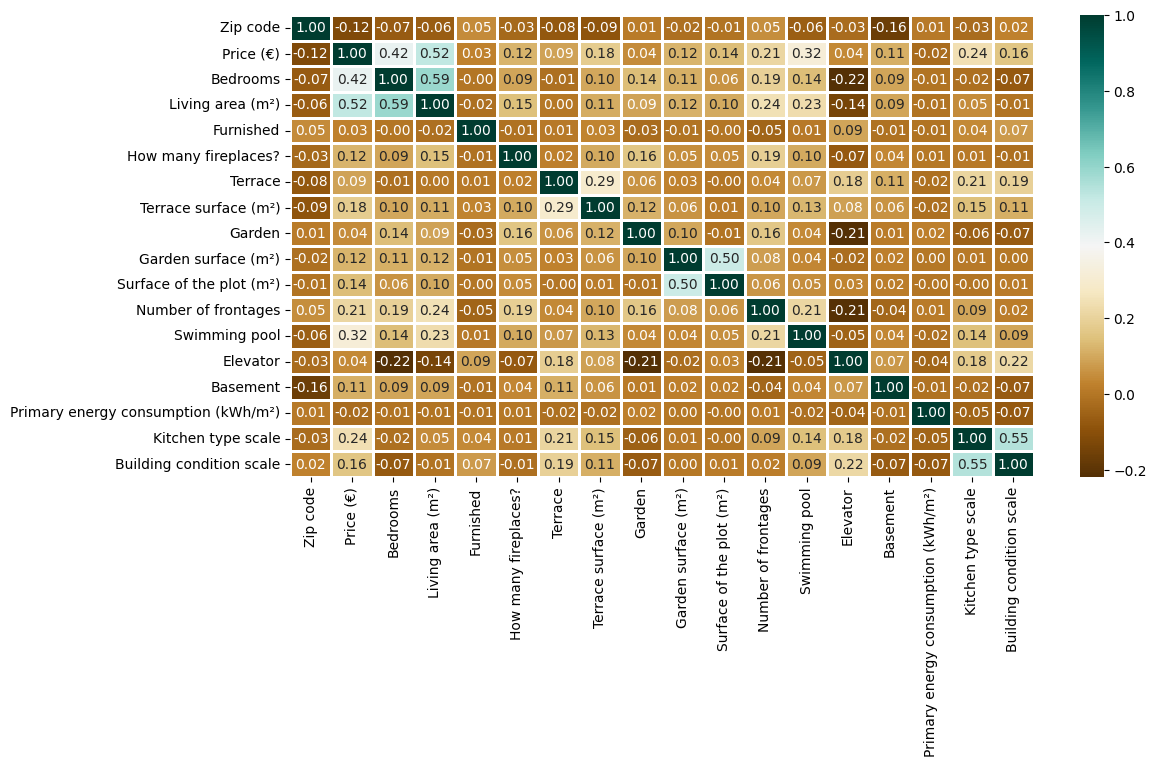

In [146]:
plt.figure(figsize=(12, 6))
sns.heatmap(df__pro_num.corr(),
            cmap = 'BrBG',
            fmt = '.2f',
            linewidths = 2,
            annot = True)

<Axes: title={'center': 'No. Unique values of Categorical Features'}>

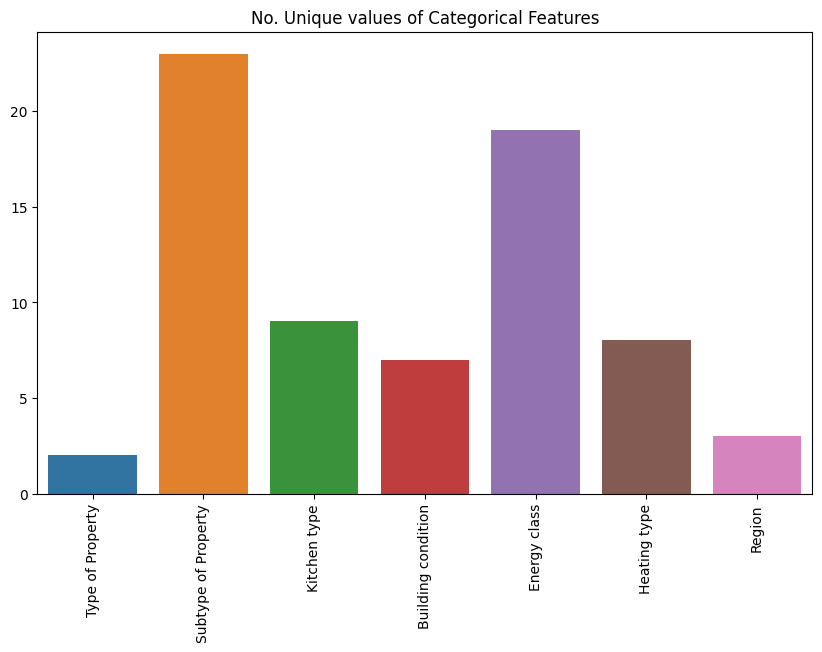

In [147]:
unique_values = []
for col in object_cols:
  unique_values.append(df_processed[col].unique().size)
plt.figure(figsize=(10,6))
plt.title('No. Unique values of Categorical Features')
plt.xticks(rotation=90)
sns.barplot(x=object_cols,y=unique_values)

/var/folders/9g/mm9pdxg52dn6rg0rtfk14syc0000gn/T/ipykernel_70866/2838185598.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(11, 4, index)


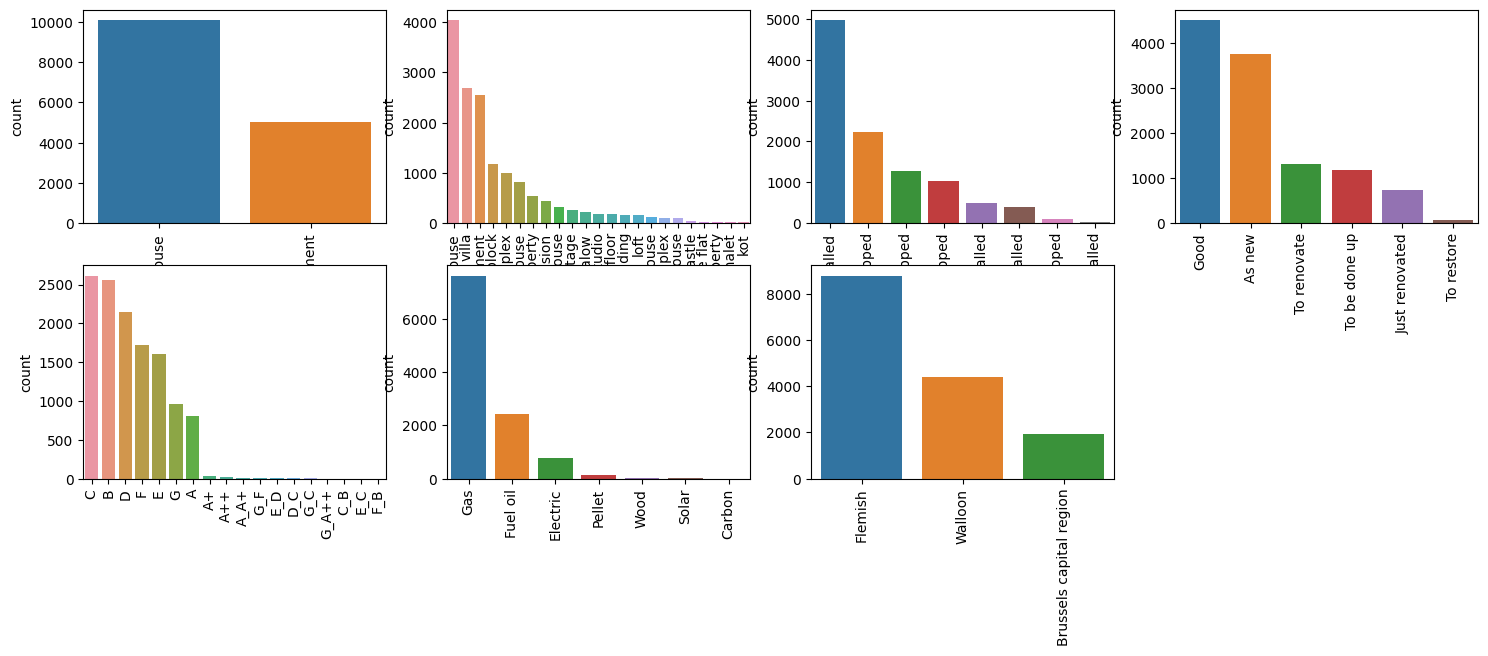

In [148]:
plt.figure(figsize=(18, 36))
plt.title('Categorical Features: Distribution')
plt.xticks(rotation=90)
index = 1
 
for col in object_cols:
    y = df_processed[col].value_counts()
    plt.subplot(11, 4, index)
    plt.xticks(rotation=90)
    sns.barplot(x=list(y.index), y=y)
    index += 1

In [149]:
df_processed = df_processed.drop(['Elevator', 'Primary energy consumption (kWh/m²)', 'Furnished'], axis=1)

In [150]:
# df_dummies = pd.get_dummies(df_processed['Type of Property'], drop_first=True)
# df_processed = pd.concat([df_processed, df_dummies], axis=1)
# df_processed = df_processed.drop('Type of Property', axis=1)

# df_dummies = pd.get_dummies(df_processed['Region'], drop_first=True)
# df_processed = pd.concat([df_processed, df_dummies], axis=1)
# df_processed = df_processed.drop('Region', axis=1)

# df_dummies = pd.get_dummies(df_processed['Subtype of Property'], drop_first=True)
# df_processed = pd.concat([df_processed, df_dummies], axis=1)
# df_processed = df_processed.drop('Subtype of Property', axis=1)

In [151]:
df_processed.isnull().sum()

Zip code                       0
Type of Property               0
Subtype of Property            0
Price (€)                      0
Bedrooms                       0
Living area (m²)               0
Kitchen type                4631
How many fireplaces?           0
Terrace                        0
Terrace surface (m²)           0
Garden                         0
Garden surface (m²)            0
Surface of the plot (m²)    5868
Number of frontages         3320
Swimming pool                  0
Building condition          3609
Basement                       0
Energy class                2665
Heating type                4150
Kitchen type scale          4631
Building condition scale    3609
Region                         0
dtype: int64

In [152]:
df['Garden surface (m²)'].dtypes

dtype('float64')

In [ ]:
# df['Garden'] = pd.to_numeric(df['Garden'])
# df['Garden surface (m²)'] = pd.to_numeric(df['Garden surface (m²)'])
# filter_S = ((df['Garden'] == 1) & (df["Garden surface (m²)"] == 0))
# df.loc[filter_S, 'Garden surface (m²)'] = df['Garden surface (m²)'].mean()